In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import lstsq
import scipy.optimize as opt
from tqdm.notebook import tqdm

sns.set(color_codes=True)
mpl.rcParams['figure.dpi'] = 120

In [2]:
df1 = pd.read_csv('Канал 1_800nm_0.2.csv', delimiter=';')
df1.columns = ['мВ', 'мА']
df2 = pd.read_csv('Канал 2_800nm_0.2.csv', delimiter=';')
df2.columns = ['мВ', 'мА']

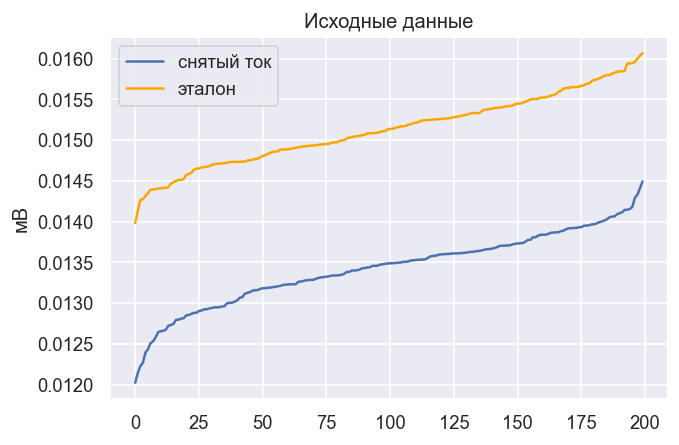

In [3]:
plt.title('Исходные данные')

plt.plot(df1['мВ'], label='снятый ток', color='b')
plt.plot(df2['мВ'], label='эталон', color='orange')
plt.legend()
plt.ylabel('мВ')
plt.show()

In [4]:
eps = 1e-4

In [5]:
df1['infV'] = df1['мВ'] - eps
df1['supV'] = df1['мВ'] + eps

df2['infV'] = df2['мВ'] - eps
df2['supV'] = df2['мВ'] + eps

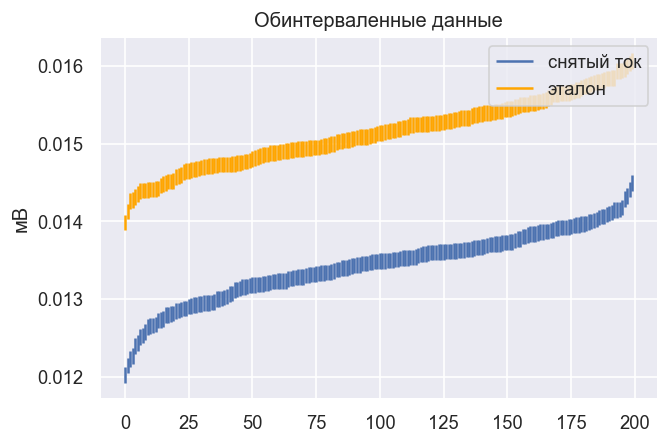

In [6]:
plt.title('Обинтерваленные данные')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='orange')

plt.legend()
plt.ylabel('мВ')

plt.show()

In [7]:
x = np.arange(len(df1))
A = np.vstack([x, np.ones(len(x))]).T

In [8]:
sol1 = lstsq(A, df1['мВ'])[0]
sol2 = lstsq(A, df2['мВ'])[0]

mnk1 = sol1[0] * x + sol1[1]
mnk2 = sol2[0] * x + sol2[1]

<ipython-input-8-056569733eaf>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol1 = lstsq(A, df1['мВ'])[0]
<ipython-input-8-056569733eaf>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol2 = lstsq(A, df2['мВ'])[0]


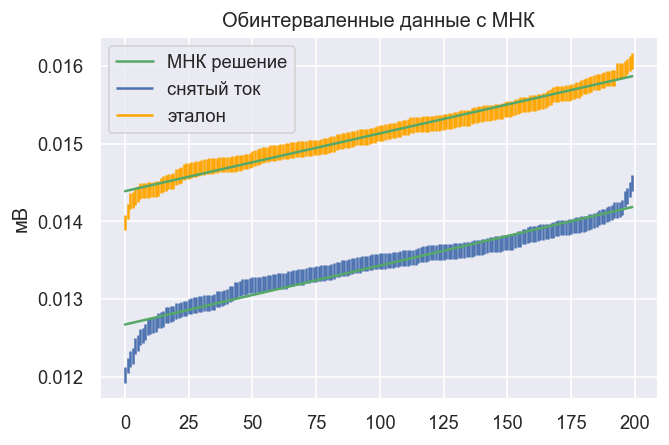

In [9]:
plt.title('Обинтерваленные данные с МНК')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='orange')
plt.plot(x, mnk2, c='g' ,label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [10]:
w1 = []
for pred, tg in zip(mnk1, df1['мВ']):
    w1.append(max(abs(pred-tg) / eps, 1))
w1 = np.array(w1)

w2 = []
for pred, tg in zip(mnk2, df2['мВ']):
    w2.append(max(abs(pred-tg) / eps, 1))
w2 = np.array(w2)

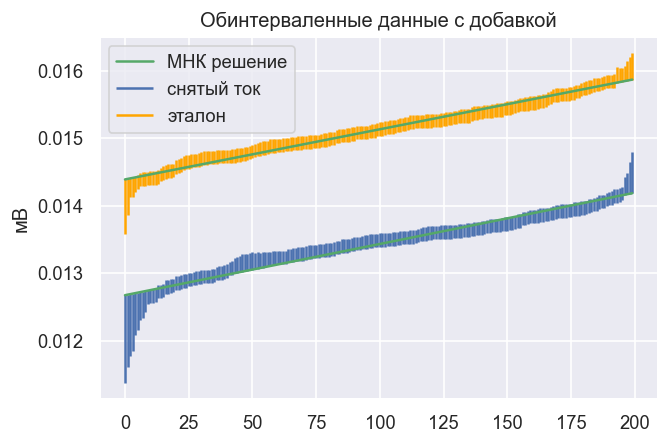

In [11]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-[i*eps for i in w1], df1['мВ']+[i*eps for i in w1], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(x, df2['мВ']-[i*eps for i in w2], df2['мВ']+[i*eps for i in w2], label='эталон', colors='orange')
plt.plot(x, mnk2, c='g',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

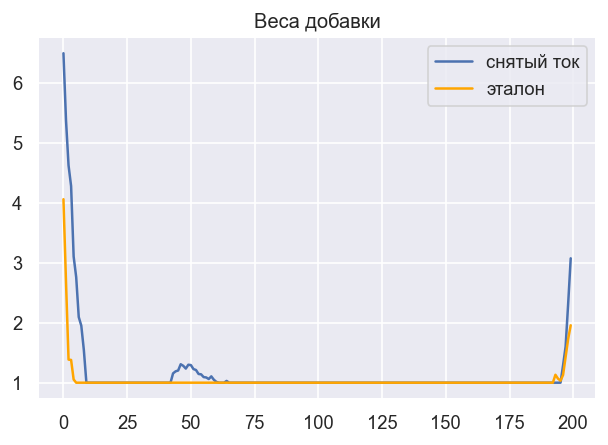

In [12]:
plt.title('Веса добавки')
plt.plot(w1, label='снятый ток', color='b')
plt.plot(w2, label='эталон', color='orange')
plt.legend()

plt.show()

In [13]:
new_rad1 = max(w1) * eps
new_rad2 = max(w2) * eps

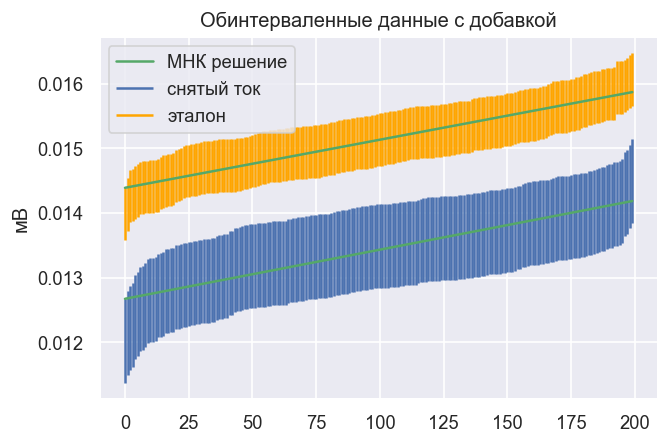

In [14]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-new_rad1, df1['мВ']+new_rad1, label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(x, df2['мВ']-new_rad2, df2['мВ']+new_rad2, label='эталон', colors='orange')
plt.plot(x, mnk2, c='g',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [37]:
def get_info(data, rad):
    bt = []
    for b in tqdm(np.arange(data[0] - rad, data[0] + rad, 1e-6)):
        for i in range(1, len(data)):
            k = (data[i] - rad - b) / i
            y = b + k * x
            if ((data - rad) <= y).all() and ((data + rad) >= y).all():
                bt.append([b, k])

            k = (data[i] + rad - b) / i
            y = b + k * x
            if ((data - rad) <= y).all() and ((data + rad) >= y).all():
                bt.append([b, k])
    bt = np.array(bt)
    
    btdf = pd.DataFrame(bt).groupby(0).agg(list).reset_index()
    b0 = btdf[0].tolist()
    b0 = b0 + b0[::-1]
    b1 = np.array(btdf[1].tolist())
    b1 = list(b1.max(axis=1)) + list(b1.min(axis=1))[::-1]
    
    x_ptp = bt[:, 0].max() - bt[:, 0].min()
    y_ptp = bt[:, 1].max() - bt[:, 1].min()
    
    plt.title('Информационное множество')
    plt.xlim(bt[:, 0].min() - x_ptp * 0.1, bt[:, 0].max() + x_ptp * 0.1)
    plt.ylim(bt[:, 1].min() - y_ptp * 0.1, bt[:, 1].max() + y_ptp * 0.1)
    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([b0, b1]).T, color='g'))

    axes.add_patch(mpl.patches.Polygon(
        [(bt[:, 0].min(), bt[:, 1].min()),
         (bt[:, 0].min(), bt[:, 1].max()),
         (bt[:, 0].max(), bt[:, 1].max()),
         (bt[:, 0].max(), bt[:, 1].min())], 
        color='r', 
        fill=False
    ))

    plt.xlabel('\u03B20')
    plt.ylabel('\u03B21')
    plt.show()
    
    bbox = []
    for i in x:
        bbox.append([row[0] + i * row[1] for row in bt])

    bbox = np.array(bbox)
    
    plt.title('Диаграмма рассеяния и коридор совместности')
    plt.vlines(x, data-rad, data+rad, label='снятый ток', colors='b')

    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([list(x) + list(x[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='g',
                                              alpha=0.5,
                                              zorder=3))
    
    return bt

  0%|          | 0/1298 [00:00<?, ?it/s]

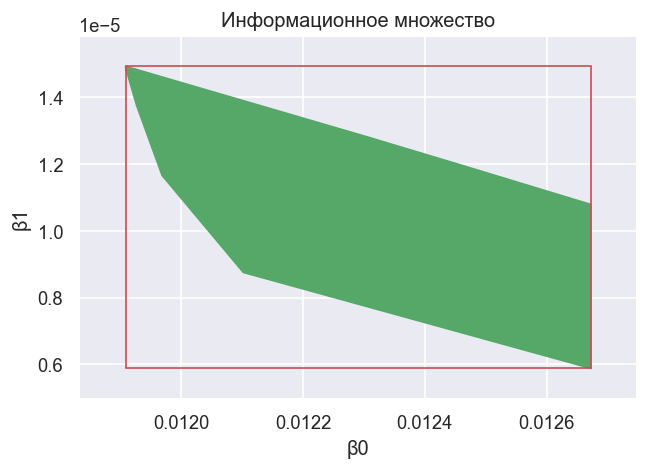

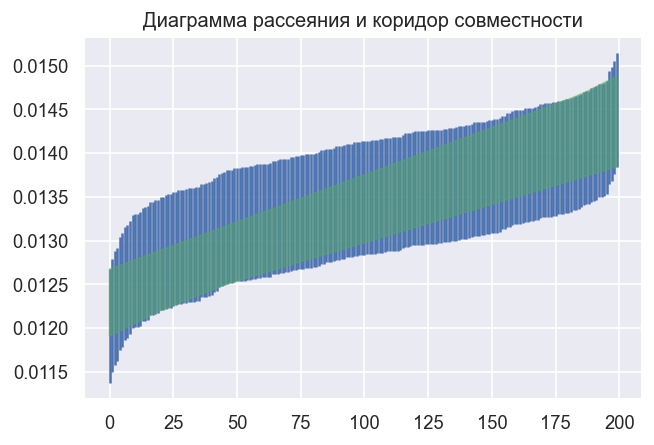

In [38]:
bt1 = get_info(df1['мВ'].tolist(), new_rad1)

  0%|          | 0/812 [00:00<?, ?it/s]

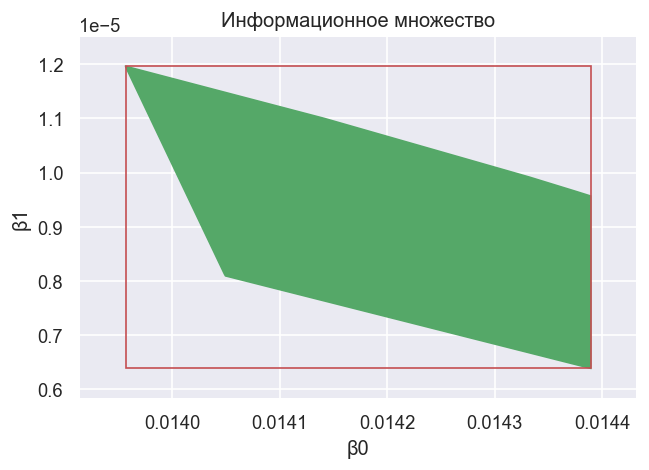

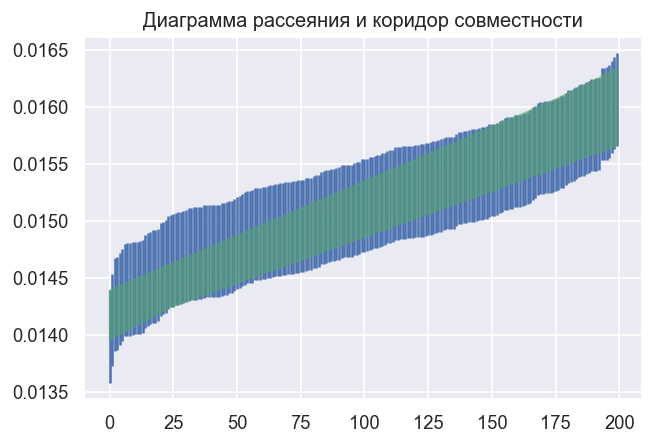

In [39]:
bt2 = get_info(df2['мВ'].tolist(), new_rad2)

In [27]:
def plot_predict(df, rad, bt, lag=20):
    bbox = []
    for i in x:
        bbox.append([row[0] + i * row[1] for row in bt])

    bbox = np.array(bbox)
    
    d_max_otr = bbox.max(axis=1)[1] - bbox.max(axis=1)[0]
    d_max_pos = bbox.max(axis=1)[-1] - bbox.max(axis=1)[-2]
    d_min_otr = bbox.min(axis=1)[1] - bbox.min(axis=1)[0]
    d_min_pos = bbox.min(axis=1)[-1] - bbox.min(axis=1)[-2]

    x_otr = []
    y_otr = []
    for i, j in enumerate(np.arange(0, -lag, -1)):
        x_otr.append(j)
        y_otr.append(bbox.max(axis=1)[0] - d_max_otr*i)

    for i, j in enumerate(np.arange(-(lag-1), 1)):
        x_otr.append(j)
        y_otr.append(bbox.min(axis=1)[0] - d_min_otr*(lag-i))

    x_pos = []
    y_pos = []
    for i, j in enumerate(np.arange(len(df), len(df)+lag)):
        x_pos.append(j)
        y_pos.append(bbox.max(axis=1)[-1] + d_max_pos*i)

    for i, j in enumerate(np.arange(len(df)+lag-1, len(df)-1, -1)):
        x_pos.append(j)
        y_pos.append(bbox.min(axis=1)[-1] + d_min_pos*(lag-i))
        
    plt.title('Диаграмма рассеяния и коридор совместности внутри и вне интервала имеющихся данных')
    plt.vlines(x, df['мВ']-rad, df['мВ']+rad, label='снятый ток', colors='b')

    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([list(x) + list(x[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='g',
                                              alpha=0.5,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([list(x) + list(x[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='g',
                                              alpha=0.5,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([x_otr, y_otr]).T,
                                              color='r',
                                              alpha=0.5,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([x_pos, y_pos]).T,
                                              color='r',
                                              alpha=0.5,
                                              zorder=3))

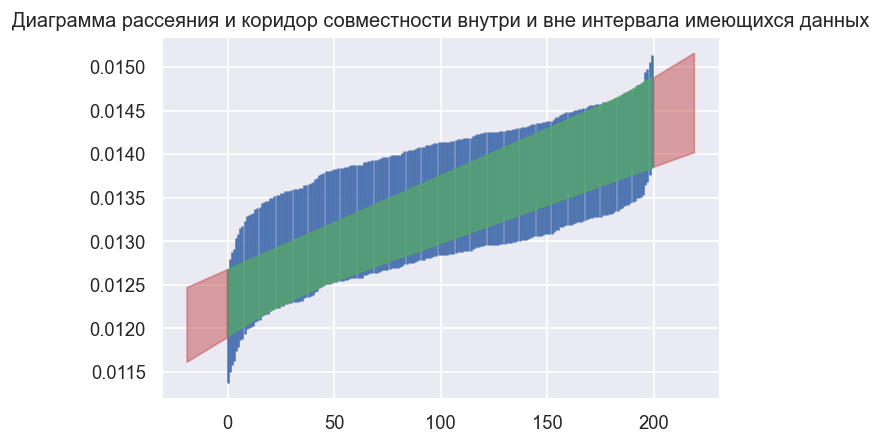

In [28]:
plot_predict(df1, new_rad1, bt1)

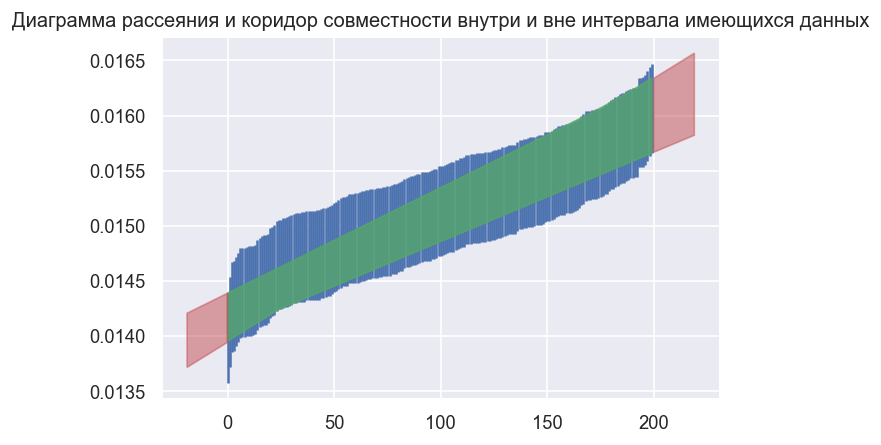

In [29]:
plot_predict(df2, new_rad2, bt2)

In [30]:
h_mnk1 = mnk1 - sol1[1]
h_mnk2 = mnk2 - sol2[1]

In [31]:
df1['infI'] = df1['мВ'] - new_rad1 - h_mnk1
df1['supI'] = df1['мВ'] + new_rad1 - h_mnk1

df2['infI'] = df2['мВ'] - new_rad2 - h_mnk2
df2['supI'] = df2['мВ'] + new_rad2 - h_mnk2

  0%|          | 0/1298 [00:00<?, ?it/s]

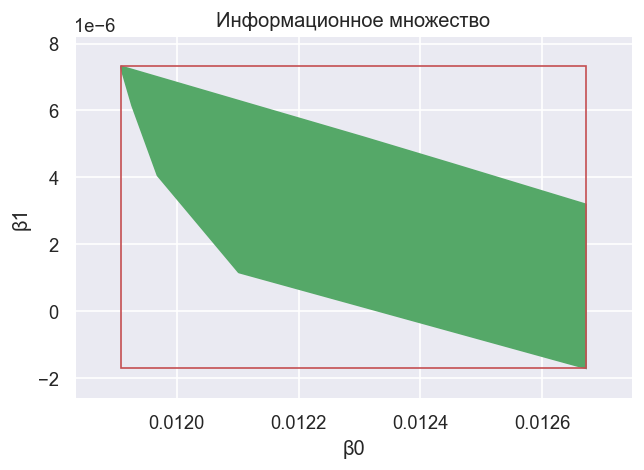

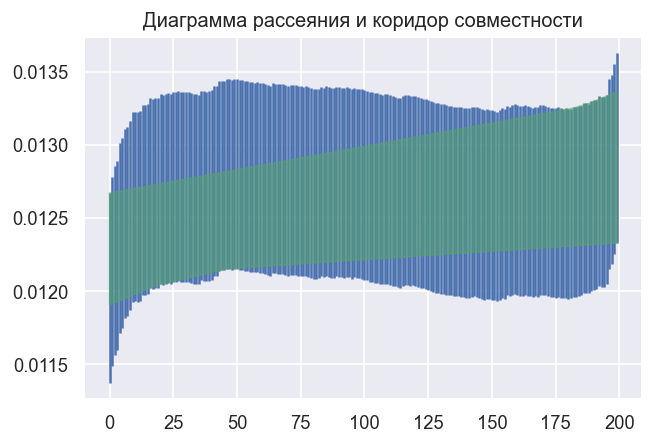

In [40]:
get_info((df1['мВ']- h_mnk1).tolist(), new_rad1);

  0%|          | 0/812 [00:00<?, ?it/s]

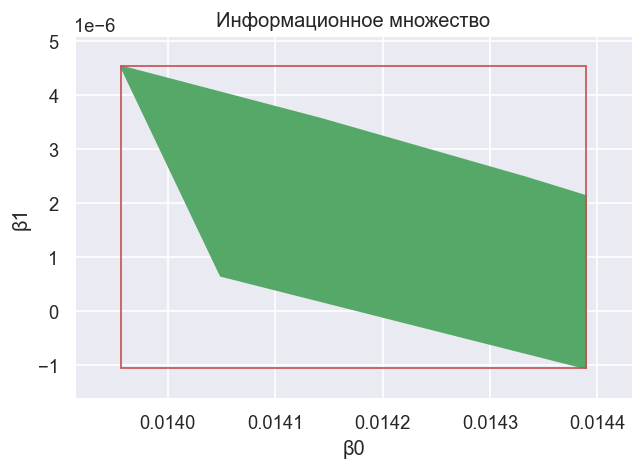

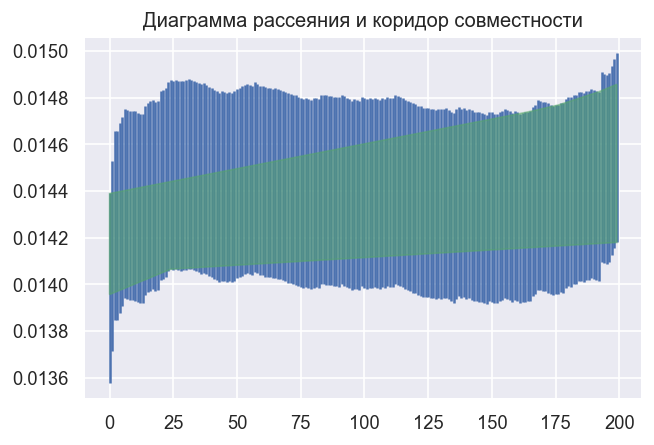

In [41]:
get_info((df2['мВ']- h_mnk2).tolist(), new_rad2);

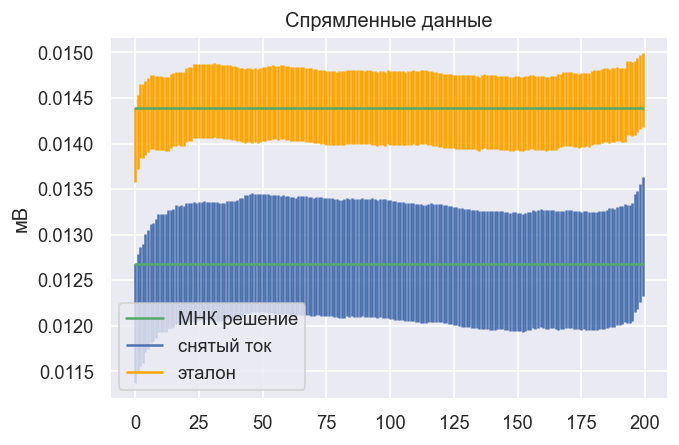

In [23]:
plt.title('Спрямленные данные')

plt.vlines(x, df1['infI'], df1['supI'], label='снятый ток', colors='b')
plt.plot(x, [sol1[1] for _ in x], c='g')

plt.vlines(x, df2['infI'], df2['supI'], label='эталон', colors='orange')
plt.plot(x, [sol2[1] for _ in x], c='g', label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [24]:
def JK(R):
    sup2 = df2['supI'].tolist()
    inf2 = df2['infI'].tolist()
    
    sup1 = (df1['supI'] * R).tolist()
    inf1 = (df1['infI'] * R).tolist()
    
    nom = min(min(sup1), min(sup2)) - max(max(inf1), max(inf2))
    denom = max(max(sup1), max(sup2)) - min(min(inf1), min(inf2))
    
    return nom / denom

In [25]:
jk = []
r = np.arange(1, 1.5001, .0001)
for i in r:
    jk.append(JK(i))
    
res = opt.fmin(lambda x: -JK(x), 1)[0]

Optimization terminated successfully.
         Current function value: -0.082070
         Iterations: 14
         Function evaluations: 28


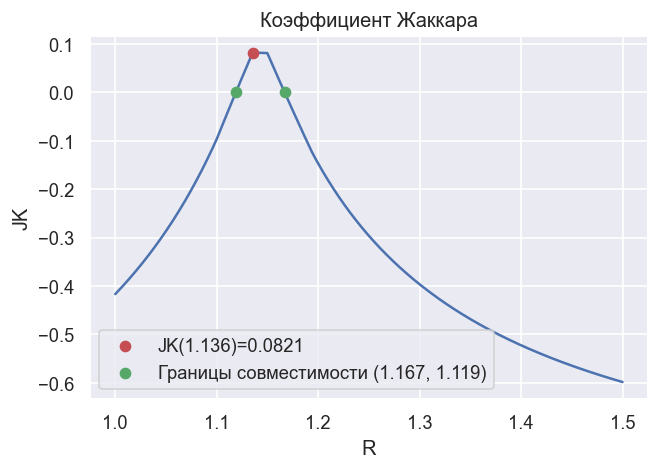

In [26]:
plt.title('Коэффициент Жаккара')
plt.plot(r, jk)
plt.scatter([res], 
            [JK(res)], 
            c='r', 
            label='JK('+'{:.3f}'.format(res)+')=' +'{:.4f}'.format(JK(res)),
            zorder=3
           )


root1 = opt.root(lambda x: -JK(x), 1).x[0]
root2 = opt.root(lambda x: -JK(x), 2).x[0]

plt.scatter([root1, root2], 
            [0, 0], 
            c='g', 
            label='Границы совместимости ('+'{:.3f}'.format(root1)+', '+'{:.3f}'.format(root2)+')',
            zorder=3
           )


plt.xlabel('R')
plt.ylabel('JK')
plt.legend()

plt.show()